In [1]:
import numpy as np
from qiskit import *
%config InlineBackend.figure_format = 'svg'
from scipy.optimize import minimize, minimize_scalar

from qiskit.visualization import *
import matplotlib.pyplot as plt
%matplotlib inline

### Some global variables 
shots = 5000
visualization = True 

**Disclaimer: If you view this on the Github website, my \ket & \bra Latex macros don't seem to be rendering. To view properly, please run the Markdown cells locally.**

<!--- Defining Latex macros -->
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$

## Decomposing the Hamiltonian

In [2]:
hamiltonian = [[0, 0, 0, 0], 
             [0, -1, 1, 0], 
             [0, 1, -1, 0], 
             [0, 0, 0, 0]]

Our Hamiltonian is a 2-qubit operator, so let's compute 2-tensored Pauli matrices to see what we can decompose it into. Using the Kronecker product, this isn't so bad. 

$$I \otimes I = \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1 \end{bmatrix}$$

$$ X \otimes X = \begin{bmatrix} 0 & 0 & 0 & 1\\ 0 & 0 & 1 & 0\\ 0 & 1 & 0 & 0\\ 1 & 0 & 0 & 0 \end{bmatrix}$$

$$ Y \otimes Y = \begin{bmatrix} 0 & 0 & 0 & -1\\ 0 & 0 & 1 & 0\\ 0 & 1 & 0 & 0\\ -1 & 0 & 0 & 0 \end{bmatrix}$$

$$ Z \otimes Z = \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & -1 & 0 & 0\\ 0 & 0 & -1 & 0\\ 0 & 0 & 0 & 1 \end{bmatrix}$$

It is clear from this that the 4 most basic 2-qubit operators all have 0's everywhere except for a main diagonal. This is useful because our Hamiltonian has only non-zero values in the 4 center spots. 

Notice the Hamiltonian is $$H = \frac{1}{2} ( X \otimes X + Y \otimes Y + Z \otimes Z - I \otimes I )$$

## Creating the ansatz

In [3]:
def gen_ansatz(theta):
    """Returns QuantumCircuit, QuantumRegister, and ClassicalRegister components of ansatz """
    # Recommended ansatz: (IX) CX (RZ I) (HI) |00> 
    qc = QuantumCircuit()
    qr = QuantumRegister(2,'qreg')
    qc.add_register( qr )
    qc.h( qr[0] )
    qc.rz(theta, qr[0] )
    qc.cx( qr[0], qr[1] )
    qc.x( qr[1] )
    cr = ClassicalRegister(2,'creg')
    qc.add_register(cr)

    #return qc.draw(output='mpl')
    return qc, qr, cr

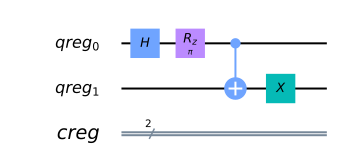

In [4]:
gen_ansatz(np.pi)[0].draw(output='mpl')

## Calculating expectation

Using [Davit Khachatryan's explanation of the 1-qubit example](https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb), we can do similar calculations to figure out how to get the expecation of 2-qubit observables: 

Since we know that all the Pauli operators have the same eigenvalues, once we calculate what we need to measure for one Pauli operator, we know it'll be the same thing for the others in their respective bases. For simplicity, I'll do the calculations in the $Z \otimes Z$ basis because it's the computational basis. 

For some qubit $\ket{\psi}$ we have 
$$\ket{\psi} = c_{00}^z \ket{00} + c_{01}^z \ket{01} + c_{10}^z \ket{10} + c_{11}^z \ket{11}$$

Calculating expectation: 
$$ \bra{\psi} Z \otimes Z \ket{\psi} = \bra{\psi} \big( c_{00}^z \ket{00} - c_{01}^z \ket{01} - c_{10}^z \ket{10} + c_{11}^z \ket{11} \big) = \mid c_{00}^z \mid^2 - \mid c_{01}^z \mid^2 - \mid c_{10}^z \mid^2 + \mid c_{11}^z \mid^2$$

So this means we need to measure the ansatz in the computational basis and then combine the probabilities like so: $$prob(00) + prob(11) - prob(01) - prob(10)$$. 

Since the Pauli $X$ and $Y$ also have +1, -1 eigenvalues for their respective bases, we know we'll get the same outcome for expectation. This means our above equation for calculating expectation from probabilities works for them too. 

Notice we don't have to calculate the expectation for observable $I \otimes I$ because 
$$ \langle I \otimes I \rangle = \bra{\psi} I \otimes I \ket{\psi} = \langle \psi \rvert \psi \rangle = 1 $$
so instead we can just subtract $\frac{1}{2}$ from the remaining expectation.

## Changing basis

Finally we have to measure the Pauli observables in their respective eigenbases. 

$Z \otimes Z$ has the computational basis as its eigenbasis, so we don't need to do anything. 

$X \otimes X$ has the Hadamard basis as its eigenbasis, since $X \ket{+} = \ket{+}$ and $X \ket{-} = - \ket{-}$. So we need to apply a basis transformation that maps $\ket{+}, \ket{-} \rightarrow \ket{0}, \ket{1}$. Of course, the Hadamard gate does this, so we need to just apply it to both qubits in the ansatz. 

$Y \otimes Y$ is a little less conventional. $Y$ has eigenvectors 
$$ \ket{+i} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1\\ i \end{bmatrix} \text{ and } \ket{-i} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1\\ -i \end{bmatrix} $$
So we need a unitary matrix to map $\ket{+i}, \ket{-i} \rightarrow \ket{0}, \ket{1}$. This is simpler than it seems with the following lemma: 

**Lemma 1:** For orthonormal bases $\ket{v_i}, \ket{w_i}$ such that $\ket{w_i} = U \ket{v_i}$, $U = \sum_i  \ket{w_i} \bra{v_i}$. 

*Proof:* (from Nielsen and Chuang p71) $$ \sum_i \ket{w_i} \bra{v_i} = \sum_i U \ket{v_i} \bra{v_i} = U I = U $$ where the second equality follows from the Completeness Relation. 

Using this, the unitary we need to measure in $Y$ basis is simply: $$ U = \ket{0} \bra{+i} + \ket{1} \bra{-i} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & -i\\ 1 & i \end{bmatrix}  $$

In [5]:
def measure(basis, theta):
    """We change to appropriate basis and measure.
        basis: 'XX', 'YY', or 'ZZ'
    """

    qc, qr, cr = gen_ansatz(theta)

    if basis == 'XX':
        qc.h( qr[0] )
        qc.h( qr[1] )
    elif basis == 'YY': 
        qc.u3( np.pi/2, 0, np.pi/2, qr[0] ) # Qiskit's U3 gate can describe any unitary - it defines our Y gate
        qc.u3( np.pi/2, 0, np.pi/2, qr[1] )
    elif basis == 'ZZ': 
        pass
    else: 
        raise ValueError("Basis must be one of 'XX', 'YY', 'ZZ'.")
    
    qc.measure( qr[0],cr[0] )
    qc.measure( qr[1],cr[1] )
    
    backend = Aer.get_backend('qasm_simulator')
    job = execute( qc, backend, shots=shots )
    
    return job.result().get_counts()

In [6]:
thetas = []

# This is our function to be minimized so it needs to output a float (the upper bound on ground state energy)
def vqe(theta): 
    if visualization:
        thetas.append(theta)
    
    # Measure in XX basis 
    xx = measure('XX', theta)
    
    # Measure in YY basis 
    yy = measure('YY', theta)
    
    # Measure in ZZ basis 
    zz = measure('ZZ', theta)
    
    # Calculate expectation by combining probabilities like so: 00 + 11 - 01 - 10 
    exp = 0
    for dic in [xx, yy, zz]:
        for ket in ['00', '11']:
            exp += dic.get(ket, 0) / shots
        for ket in ['01', '10']: 
            exp -= dic.get(ket, 0) / shots 
        
    
    # Subtract 1 for II, apply coefficient of 1/2, then return 
    return 0.5 * (exp - 1)

In [7]:
sol = minimize_scalar(vqe, bounds=(0, 2*np.pi), method='bounded')

print("VQE came up with an upper bound of " + str(sol.fun))

VQE came up with an upper bound of -2.0


Let's compute the eigenvalues using NumPy so we can check our answers... The lowest eigenvalue is -2 which is what we got too!

In [8]:
np.linalg.eig(hamiltonian)

(array([ 0., -2.,  0.,  0.]),
 array([[ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.70710678, -0.70710678,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

## Investigating our arrival at the solution

In [9]:
# Here's the full OptimizeResult object SciPy gives us after minimizing - notice nfev = 28, that's the number of inputs the minimizer had to try to reach the the optimum
sol

     fun: -2.0
 message: 'Solution found.'
    nfev: 28
  status: 0
 success: True
       x: 3.1353576051700998

Since there weren't too many iterations with the given ansatz for us to reach the minimum, let's look at how the theta value for the ansatz progressed.

In [10]:
for theta in thetas: 
    print(theta)

2.399963229728653
3.8832220774509327
1.4832588477222797
3.133610154537081
3.1351519556194134
3.134381055078247
3.420889316190779
3.244293915501991
3.1768404746957803
3.151075552965937
3.1609168773492566
3.1449932800027325
3.1412342285826176
3.1389110070395283
3.137475177162503
3.136587785496439
3.136039347285478
3.135700393830375
3.135490909074517
3.1353614403752714
3.1352814243186584
3.135231971676026
3.135311987732639
3.135330876961291
3.135342551146619
3.135349766189943
3.1353542253319477
3.1353576051700998


Here's an ansatz from [this paper](https://arxiv.org/pdf/quant-ph/0308033.pdf) that I came across while on the [Qiskit explanation of VQE](https://qiskit.org/textbook/ch-applications/vqe-molecules.html) that's supposed to be able to get to every single 2-qubit state. 

Notice the crazy number of parameters which is why having good heuristics is recommended. Here's what our variational circuit looks like: 
![From Qiskit](https://qiskit.org/textbook/ch-applications/images/two_qubit_var_form.png)

In [11]:
def gen_ansatz(theta):
    # Overkill ansatz; notice we're redefining gen_ansatz so we don't have to rewrite vqe function
    t0, p0, l0, t1, p1, l1, t2, p2, l2, t3, p3, l3, t4, p4, l4, t5, p5, l5, t6, p6, l6, t7, p7, l7 = theta
    qc = QuantumCircuit()
    qr = QuantumRegister(2, 'qreg')
    qc.add_register( qr )
    qc.u3(t0, p0, l0, qr[0]) 
    qc.u3(t1, p1, l1, qr[1]) 
    qc.cnot(qr[1], qr[0])
    qc.u3(t2, p2, l2, qr[0])
    qc.u3(t3, p3, l3, qr[1])
    qc.cnot(qr[0], qr[1])
    qc.u3(t4, p4, l4, qr[0])
    qc.u3(t5, p5, l5, qr[1])
    qc.cnot(qr[1], qr[0])
    qc.u3(t6, p6, l6, qr[0])
    qc.u3(t7, p7, l7, qr[1])
    cr = ClassicalRegister(2, 'creg')
    qc.add_register(cr)
    return qc, qr, cr

In [12]:
# This takes a while to run
sol = minimize(vqe, [0 for i in range(24)], method='Powell')

In [13]:
sol.fun

array(-2.)

My computer got pretty hot, but the minimizer actually still arrived at the correct solution! When I left the 'method' parameter blank, I kept getting stuck at local minima around -0.02.

In [14]:
sol.success

True

In [15]:
# The amount of iterations this took to find the minimum was 805!
sol.nfev

805

## Discovering excited states of the Hamiltonian

While reading *Quantum Computing: An Applied Approach* by Jack Hidary, I saw a reference for [Variational Quantum Computation of Excited States](https://arxiv.org/abs/1805.08138). It's a method the authors call Variational Quantum Deflation, which allows us to find other eigenvalues of a Hamiltonian using VQE, instead of just the lowest one. The reasoning behind it is simple: we iteratively run VQE but after each iteration we only look for eigenvectors that are orthogonal to all previously-found eigenvectors. Here's the cost function: 
$$Cost(\theta_k) = \bra{\psi(\theta_k)} H \ket{\psi(\theta_k)} + \sum_{i=0}^{k-1} \beta_i \mid \bra{\psi(\theta_k)} \psi(\theta_i) \rangle \mid^2  $$
where $\beta_i$ is some chosen coefficient. 

Notice that this is the same cost function as normal VQE except now we want the newest eigenvector to be orthogonal to all previous eigenvectors. 

### How to calculate inner product on a quantum computer 

What makes working with quantum computers interesting and challenging is that our only method of learning information is through measurement, which collapses the state. So we need to be really clever with how we do measurements to learn exactly the information we want. 

This paper is a good example of this because they provide a way to find out the value of $\mid \bra{\psi(\theta_k)} \psi(\theta_i) \rangle \mid^2$. 

One way of figuring this out is to decompose $\psi(\theta) = A(\theta) \ket{00}$, where $A$ is our ansatz circuit. Now we have 
$$ \mid \bra{\psi(\theta_k)} \psi(\theta_i) \rangle \mid^2 = \mid \bra{00} A(\theta_k)^\dagger A(\theta_i) \ket{00}$$

Well this is easy to find out with a quantum computer: it's the probability of getting $\ket{00}$ when measuring the state $A(\theta_k)^\dagger A(\theta_i) \ket{00}$. 

In [16]:
# Let's try it with our original ansatz
def gen_ansatz(theta):
    """Returns QuantumCircuit, QuantumRegister, and ClassicalRegister components of ansatz """
    # Recommended ansatz: (IX) CX (RZ I) (HI) |00> 
    qc = QuantumCircuit()
    qr = QuantumRegister(2,'qreg')
    qc.add_register( qr )
    qc.h( qr[0] )
    qc.rz(theta, qr[0] )
    qc.cx( qr[0], qr[1] )
    qc.x( qr[1] )
    cr = ClassicalRegister(2,'creg')
    qc.add_register(cr)

    #return qc.draw(output='mpl')
    return qc, qr, cr

# We'll need the inverse ansatz in order to do the algorithm
def gen_combined_ansatz(theta_i, theta_k):
    ansatz = gen_ansatz(theta_i)
    # Append adjoint ansatz circuit to qc of ansatz
    ansatz[0].extend(gen_ansatz(theta_k)[0].inverse())
    return ansatz

# Variational quantum deflator
def vqd(hamiltonian, initial_guess):
    thetas_so_far = [] 
    eigenvalues = []
    beta = 1
    num_eigenvectors = np.shape(hamiltonian)[0] # Assume non-degenerate 
    
    # Cost function for VQD; we compute VQE then force orthogonality between eigenvectors
    def cost(theta):
        exp = vqe(theta) 
        
        for theta_i in thetas_so_far:
            qc, qr, cr = gen_combined_ansatz(theta_i, theta)
            qc.measure( qr[0], cr[0] )
            qc.measure( qr[1], cr[1] )
            backend = Aer.get_backend('qasm_simulator')
            job = execute( qc, backend, shots=shots )
            exp += beta * job.result().get_counts().get('00', 0) / shots
        return exp
    
    for i in range(num_eigenvectors):
        sol = minimize(cost, initial_guess, method='Powell')
        if sol.success:
            thetas_so_far.append(sol.x)
            eigenvalues.append(sol.fun)
        else: 
            raise ValueError('Minimization failed.')
    return eigenvalues

In [18]:
vqd(hamiltonian, 0)

[array(-2.), array(-1.0004), array(-0.0368), array(0.01)]

In [19]:
# For this hamiltonian, we have eigenvalues of -2, 0, 0, 0 and an orthonormal basis of eigenvectors
np.linalg.eig(hamiltonian)

(array([ 0., -2.,  0.,  0.]),
 array([[ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.70710678, -0.70710678,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

Notice that we weren't able to get the exact eigenvalues - instead we got -2, -1, 0, 0. 

I can think of 2 reasons for why our algorithms got the first eigenvalue correct but not the others: 

1. The beta value needs to be optimized. Varying how much we care about orthogonality compared to VQE results will dictate our results. 

2. The ansatz isn't able to reach all the eigenvectors of the Hamiltonian. This means VQD never gets to the global minimum. This explains why we always get the first eigenvalue of -2 correct: we know the ansatz can reach that specific eigenvector (because the ansatz was given to us as a good ansatz for VQE). 

When I made beta really high, I got useless upper bounds like 100, which means that enforcing orthogonality doesn't work with this ansatz. This makes me believe problem 2 is why VQD is failing. 